<a href="https://colab.research.google.com/github/mona-jha/Machine-Learning-II/blob/main/problem_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h1><b>Assignmen-1(ML2)<b> <br>


<h2> Name : Mona Kumari <br>
Roll No. :<b> CS2311</b>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

Parameter Settings
-------------------


In [ ]:
# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)


latent_dims = 2
num_epochs = 50
batch_size = 128
capacity = 64
learning_rate = 1e-3

# weight of the regularizer
variational_beta = 1
use_gpu = True


MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We do not center them at 0, because we will be using a binary cross-entropy loss that treats pixel values as probabilities in [0,1]. We create both a training set and a test set.

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

# create training set and train dataloaders
train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# create test set and test dataloaders
test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 151359431.07it/s]


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 73593981.67it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41151323.32it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3002920.68it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



VAE Definition
-----------------------
We use a convolutional encoder and decoder, which generally gives better performance than fully connected versions that have the same number of parameters.

In [ ]:
# encoder module
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity

        # ((n - k + 2p) // s + 1)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out:[128 x c x 14 x 14]
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: [128 x 2*c x 7 x 7]

        # (B, C, H, W)
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims) #mean
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims) #log (variance)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors

        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)

        return x_mu, x_logvar

# decoder modeule
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        # ((n-1) * s + k - 2p)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):

        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss

        return x

# vae model
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):

        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):

        # the reparameterization trick
        if self.training:

            std = logvar.mul(0.5).exp_()

            # sampling from N(0, 1) ---- standard normal
            eps = torch.empty_like(std).normal_()

            # z = e * sigma + mean
            return eps.mul(std).add_(mu)

        else:
            return mu

def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.

    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.

    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence

# creating model
vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)


In [ ]:
# x = torch.rand(128, 2, 3, 4, 7, 8)
# # z = x.view(128, 6, -1)
# print(z.shape)

torch.Size([128, 6, 224])


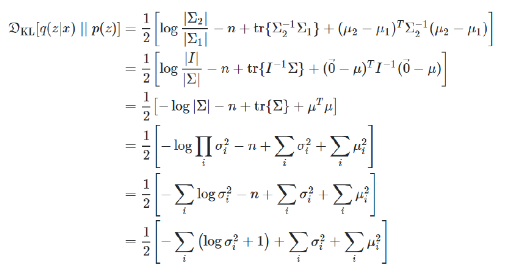


# [Details of ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html#torch.nn.ConvTranspose2d)

In [ ]:
# Learn about ConvTranspose2d

import torch
import torch.nn as nn

# (B, C, H, W)
m = nn.ConvTranspose2d(in_channels = 16, out_channels = 33, kernel_size = 3, stride=2, padding = 1)

# m = nn.ConvTranspose2d(16, 33, 5, 2, 2)

# ((n-1) * s + k - 2p)

input = torch.randn(20, 16, 50, 100)

output = m(input)
print(input.shape)
print(output.shape)

torch.Size([20, 16, 50, 100])
torch.Size([20, 33, 99, 199])


Train VAE
--------

In [ ]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in train_dataloader:

        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()

        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()

        train_loss_avg[-1] += loss.item()
        num_batches += 1

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

torch.save(vae.state_dict(), 'best_vae.pt')

Training ...
Epoch [1 / 50] average reconstruction error: 23609.004485
Epoch [2 / 50] average reconstruction error: 21153.840358
Epoch [3 / 50] average reconstruction error: 20561.147940
Epoch [4 / 50] average reconstruction error: 20292.502030
Epoch [5 / 50] average reconstruction error: 20091.014765
Epoch [6 / 50] average reconstruction error: 19941.964205
Epoch [7 / 50] average reconstruction error: 19838.525228
Epoch [8 / 50] average reconstruction error: 19756.178369
Epoch [9 / 50] average reconstruction error: 19677.445406
Epoch [10 / 50] average reconstruction error: 19631.518267
Epoch [11 / 50] average reconstruction error: 19562.895468
Epoch [12 / 50] average reconstruction error: 19527.599626
Epoch [13 / 50] average reconstruction error: 19483.145845
Epoch [14 / 50] average reconstruction error: 19436.673031
Epoch [15 / 50] average reconstruction error: 19398.745538
Epoch [16 / 50] average reconstruction error: 19368.355042
Epoch [17 / 50] average reconstruction error: 19328.

Plot Training Curve
--------------------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

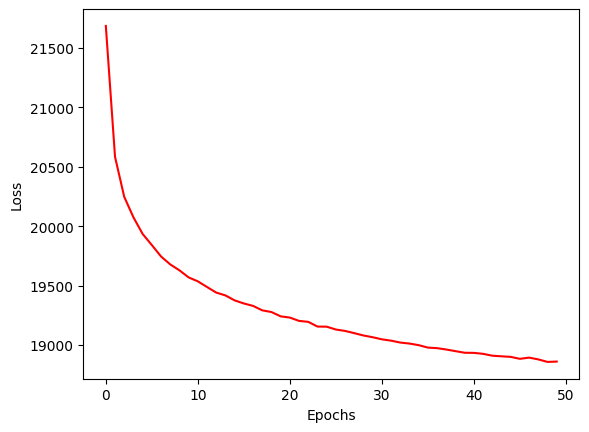

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss_avg, color = 'red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Evaluate on the Test Set
-------------------------

In [ ]:
vae.load_state_dict(torch.load('/content/best_vae.pt'))
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
  with torch.no_grad():

    image_batch = image_batch.to(device)

    # vae reconstruction
    image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

    # reconstruction error
    loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

    test_loss_avg += loss.item()
    num_batches += 1

test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 18987.107901


Visualize Reconstructions
--------------------------

images  torch.Size([128, 1, 28, 28])
Original images


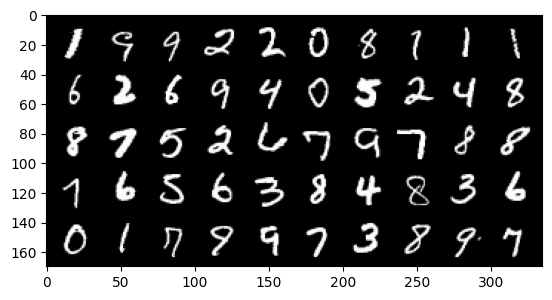

VAE reconstruction:


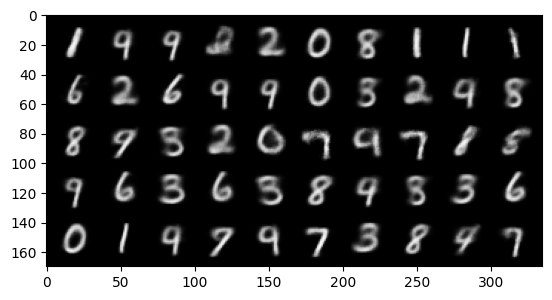

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # H, W, C

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[0:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

for images, labels in test_dataloader:

  # First visualise the original images
  print("images ", images.shape)
  print('Original images')
  z = torchvision.utils.make_grid(images[0:50],10,5)
  show_image(z)
  plt.show()

  # Reconstruct and visualise the images using the vae
  print('VAE reconstruction:')
  visualise_output(images, vae)

  break

Interpolate in Latent Space
----------------------------

In [ ]:
# z = np.random.randn(3,4,5)
# z.shape
# t = np.transpose(z, (1,2,0))
# t.shape

(4, 5, 3)

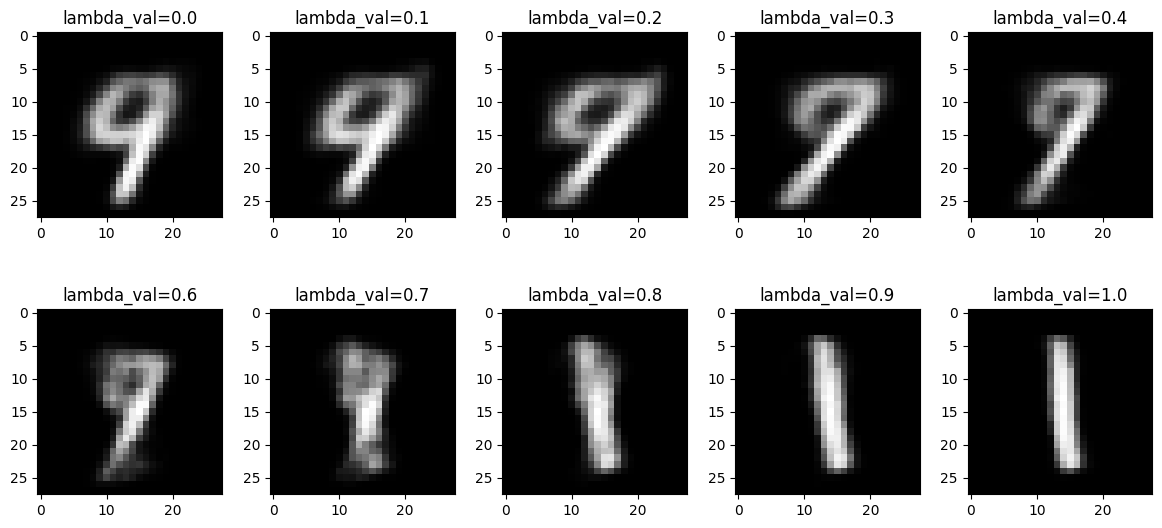

In [ ]:
vae.eval()

def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        # print(img_batch[i:i+1].shape)
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# print(digits[1][7].shape, "    ", digits[9][16].shape)

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    # print(ind)
    inter_image=interpolation(float(l), vae, digits[1][8], digits[9][6])

    # inter_image = to_img(inter_image)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show()

Sample Latent Vector from Prior (VAE as Generator)
-------------------------------------------------

A VAE can generate new digits by drawing latent vectors from the prior distribution. Although the generated digits are not perfect, they are usually better than for a non-variational Autoencoder (compare results for the 10d VAE to the results for the autoencoder).

Similar to autoencoders, the manifold of latent vectors that decode to valid digits is sparser in higher-dimensional latent spaces. Increasing the weight of the KL-divergence term in the loss (increasing `variational_beta`) makes the manifold less sparse at the cost of a lower-quality reconstruction. A pre-trained model with `variational_beta = 10` is available at `./pretrained/vae_10d_beta10.pth`.

torch.Size([128, 1, 28, 28])


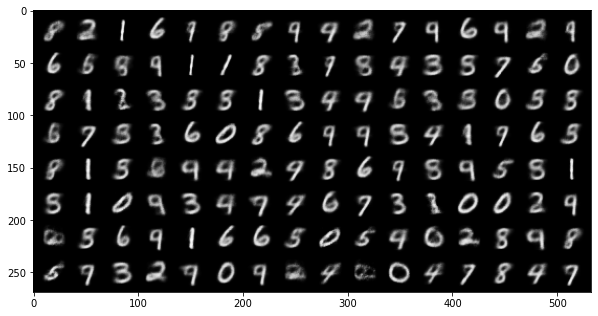

In [ ]:
vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()
    print(img_recon.shape)

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(img_recon.data[:128],16,5))
    plt.show()

Show 2D Latent Space
---------------------

20    20
recon image  torch.Size([400, 1, 28, 28])


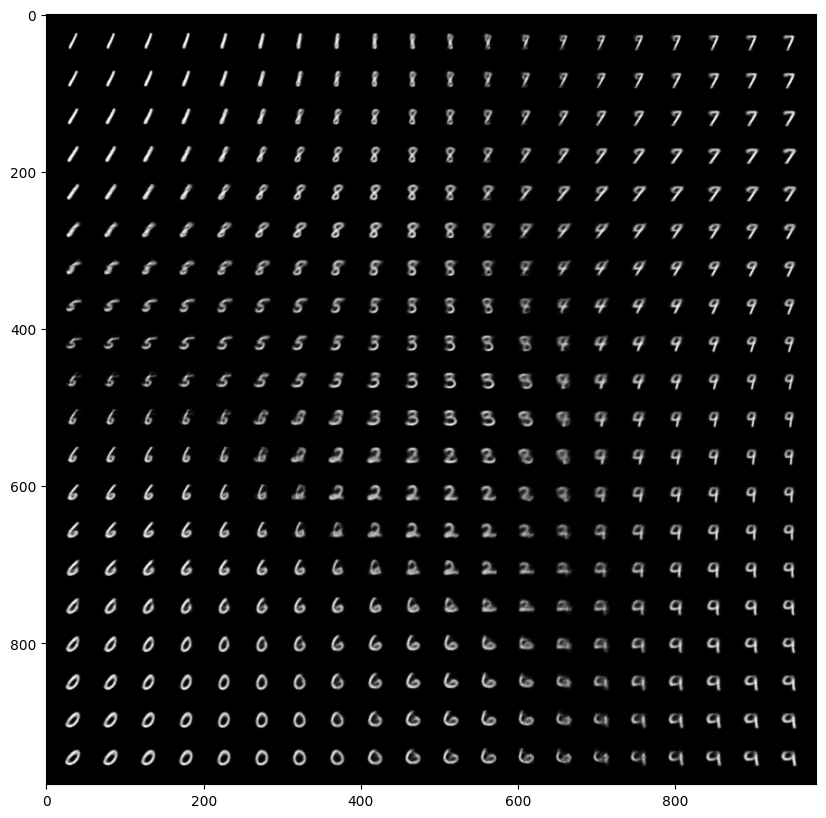

In [ ]:
# load a network that was trained with a 2d latent space
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')

with torch.no_grad():

    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    print(len(latent_x), "  ", len(latent_y))
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)

    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[i, j, 0] = lx
            latents[i, j, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    print("recon image ", image_recon.shape)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,20))
    plt.show()